In [28]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})


import nfp
from preprocess_inputs_spin_bv import preprocessor
preprocessor.from_json('tfrecords_spin_bv/preprocessor.json')

from loss import AtomInfMask, KLWithLogits
from nfp import EdgeUpdate, NodeUpdate, GlobalUpdate

%matplotlib inline

In [4]:
!nvidia-smi

Thu Feb 11 08:50:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro GV100        Off  | 00000000:37:00.0 Off |                  Off |
| 30%   42C    P0    35W / 250W |    150MiB / 32508MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [8]:
num_new_train = len(np.load('split_spin_bv.npz', allow_pickle=True)['train_new'])
# split the 3K new calculations into groups evenly spaced by log
num_train_list = np.logspace(2, np.log10(num_new_train), num=6, dtype=int)
# make sure the last entry includes all training data
num_train_list[-1] = num_new_train
num_train_list

array([ 100,  200,  403,  809, 1624, 3262])

bur_vol_loss        0.446083
loss                0.033243
spin_loss           0.010833
val_bur_vol_loss    0.503245
val_loss            0.046986
val_spin_loss       0.021098
dtype: float64
bur_vol_loss        0.449133
loss                0.033151
spin_loss           0.010630
val_bur_vol_loss    0.506388
val_loss            0.047590
val_spin_loss       0.021233
dtype: float64
bur_vol_loss        0.439884
loss                0.032948
spin_loss           0.010932
val_bur_vol_loss    0.505504
val_loss            0.047315
val_spin_loss       0.021069
dtype: float64
bur_vol_loss        0.432812
loss                0.032241
spin_loss           0.010536
val_bur_vol_loss    0.509277
val_loss            0.047279
val_spin_loss       0.020617
dtype: float64
bur_vol_loss        0.419304
loss                0.031860
spin_loss           0.010863
val_bur_vol_loss    0.514026
val_loss            0.046785
val_spin_loss       0.020569
dtype: float64
bur_vol_loss        0.397550
loss                0.0307

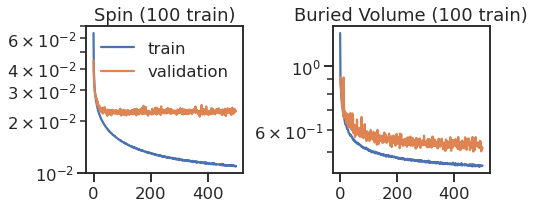

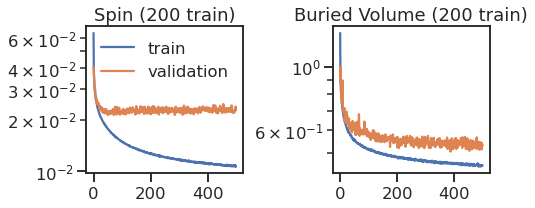

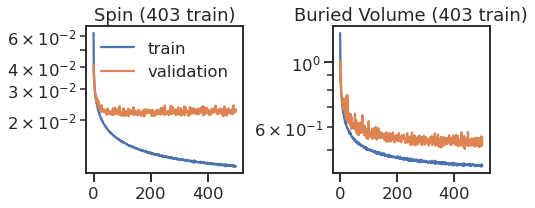

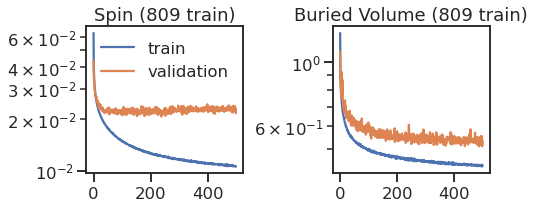

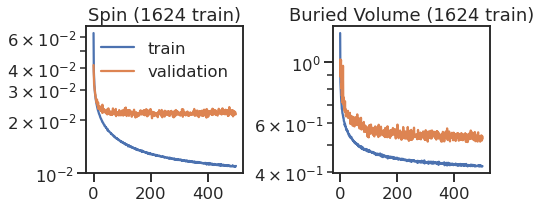

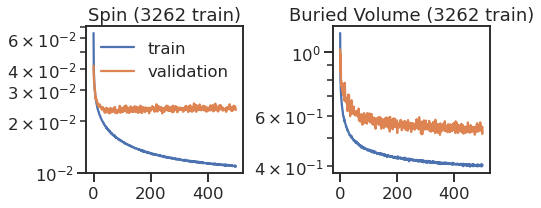

In [9]:
for num in num_train_list:
    fig, axs = plt.subplots(ncols=2, sharex=True, figsize=(7, 3))

    log2 = pd.read_csv(f'20210208_spin_bv_lc/n_{num}/log.csv', error_bad_lines=False).set_index('epoch')

    axs[0].plot(log2['spin_loss'], label='train')
    axs[0].plot(log2['val_spin_loss'], label='validation')

    axs[0].set_title(f'Spin ({num} train)')

    axs[1].plot(log2['bur_vol_loss'])
    axs[1].plot(log2['val_bur_vol_loss'])

    axs[1].set_title(f'Buried Volume ({num} train)')

    for ax in axs:
        ax.set_yscale('log')

    axs[0].legend()
#     plt.suptitle(f"{num} new training examples", fontsize=18)

    print(log2.min())


    plt.tight_layout()
    # plt.xlim([0, 10])

In [10]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [11]:
# Load the "new test" set which is the 500 of the most recent DFT calculations we left out 
test = np.load('split_spin_bv.npz', allow_pickle=True)['test_new']

In [12]:
# Load the  values
# cdf_spin = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/cdf_spins.csv.gz')
# cdf_spin = cdf_spin[cdf_spin.atom_type != 'H']

# cdf_bv = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/cdf_buried_volume.csv.gz', index_col=0)
# cdf = cdf_spin.merge(cdf_bv, on=['smiles', 'atom_index'], how='left')

# cdf['fractional_spin'] = cdf.groupby('smiles').spin.apply(lambda x: x.abs() / x.abs().sum())

from preprocess_inputs_spin_bv import new_data
cdf = new_data

cdf_test = cdf[cdf.smiles.isin(test)].copy()

In [13]:
cdf.head()

,smiles,atom_index,spin,buried_vol
0,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,0,0.085155,40.057887
1,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,1,0.024316,54.431655
2,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,2,0.009385,41.549793
3,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,3,0.001184,32.768445
4,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,4,0.345404,62.511166


In [ ]:
# # redf is where the molecules were in water? Skip for now
# redf_spin = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/redf_spins_expanded.csv.gz')
# redf_spin = redf_spin[redf_spin.atom_type != 'H']

# redf_bv = pd.read_csv('/projects/rlmolecule/svss/Project-Redox/bur-vol_data_water/buried_volumes_water_all.csv.gz')[['atom_index', 'buried_vol', 'smiles']]
# redf = redf_spin.merge(redf_bv, on=['smiles', 'atom_index'], how='left')

# redf['fractional_spin'] = redf.groupby('smiles').spin.apply(lambda x: x.abs() / x.abs().sum())

# redf_smiles = pd.Series(redf.smiles.unique())

# redf_test = redf_smiles[redf_smiles.isin(test)]

In [14]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in test),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(max_atoms=cdf_test.atom_index.max() + 1),
                  padding_values=preprocessor.padding_values)

In [ ]:
# redf_dataset = tf.data.Dataset.from_generator(
#     lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in redf_test),
#     output_types=preprocessor.output_types,
#     output_shapes=preprocessor.output_shapes)\
#     .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(max_atoms=redf.atom_index.max() + 1),
#                   padding_values=preprocessor.padding_values)

In [15]:
# store the predictions for each of the points along the learning curve
learning_curve_pred = {}
for num_train in num_train_list:
    model = tf.keras.models.load_model(
        f'20210208_spin_bv_lc/n_{num_train}/best_model.hdf5',
        custom_objects={**nfp.custom_objects,
                        **{'AtomInfMask': AtomInfMask, 'KLWithLogits': KLWithLogits}})

    predicted_spin_logits, predicted_bur_vol = model.predict(test_dataset, verbose=1)
    predicted_fractional_spins = tf.nn.softmax(predicted_spin_logits)
    learning_curve_pred[num_train] = (predicted_fractional_spins, predicted_bur_vol)

/home/jlaw/.conda-envs/dl/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['n_bond', 'bond_indices'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


4/4 [==============================] - 2s 112ms/step


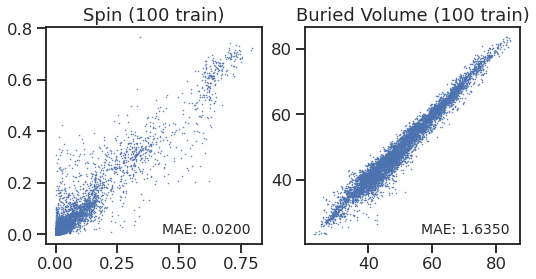

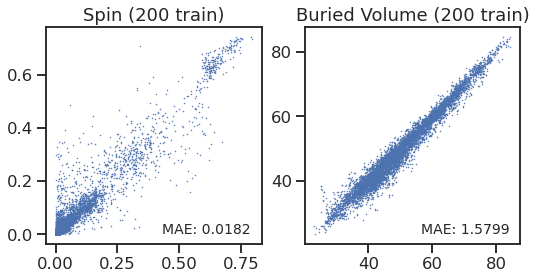

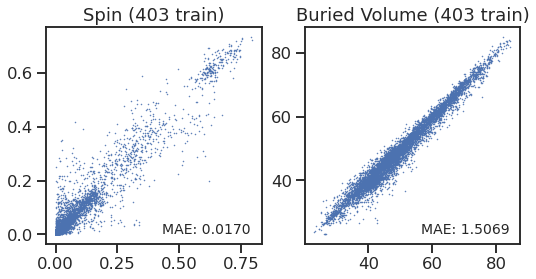

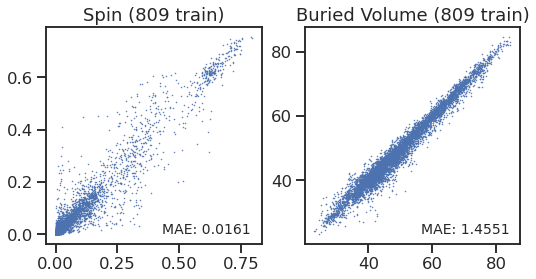

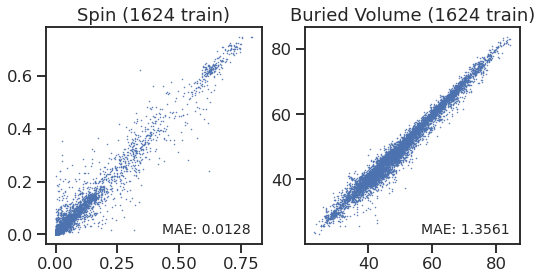

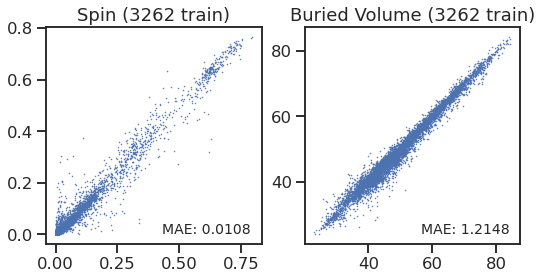

In [16]:
spin_mae_list = []
bv_mae_list = []
for num_train in num_train_list:
    predicted_fractional_spins, predicted_bur_vol = learning_curve_pred[num_train]
#     cdf_test_pivot_spins = cdf_test.pivot(index='smiles', columns='atom_index', values='fractional_spin')
    cdf_test_pivot_spins = cdf_test.pivot(index='smiles', columns='atom_index', values='spin')
    cdf_test_pivot_spins = cdf_test_pivot_spins.reindex(test)

    cdf_test_pivot_bur_vol = cdf_test.pivot(index='smiles', columns='atom_index', values='buried_vol')
    cdf_test_pivot_bur_vol = cdf_test_pivot_bur_vol.reindex(test)
    # compute the Mean Average Error
    spin_mae = pd.Series(cdf_test_pivot_spins.values.flatten() - predicted_fractional_spins.numpy().flatten()).dropna().abs().mean()
    bv_mae = pd.Series(cdf_test_pivot_bur_vol.values.flatten() - predicted_bur_vol.flatten()).dropna().abs().mean()
    # and store for later
    spin_mae_list.append(spin_mae)
    bv_mae_list.append(bv_mae)
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8.5,4))
    axs[0].plot(cdf_test_pivot_spins.values.flatten(), predicted_fractional_spins.numpy().flatten(), '.', ms=1)
    axs[0].text(.95, .05, f'MAE: {spin_mae:.4f}', ha='right',
                transform=axs[0].transAxes, fontsize=14)

    axs[1].plot(cdf_test_pivot_bur_vol.values.flatten(), predicted_bur_vol.flatten(), '.', ms=1)
    axs[1].text(.95, .05, f'MAE: {bv_mae:.4f}', ha='right',
                transform=axs[1].transAxes, fontsize=14)

    axs[0].set_title(f'Spin ({num_train} train)')
    axs[1].set_title(f'Buried Volume ({num_train} train)')

In [17]:
spin_mae_list

[0.02001574394636585,
 0.018174441140086126,
 0.016983793438665212,
 0.01614768907391891,
 0.012779690674093805,
 0.010821326387734033]

In [18]:
bv_mae_list

[1.6349636918103596,
 1.579930915867945,
 1.5068921776338562,
 1.45505829064244,
 1.3561428316983144,
 1.2148017224471572]

In [19]:
# compute a regression line of the MAE points
from scipy import stats

# spin_mae_log,bv_mae_log,num_train_log =[],[],[]
# for i, num_train in enumerate(num_train_list):
#     spin_mae_log.append(np.log10(spin_mae_list[i]))
#     bv_mae_log.append(np.log10(bv_mae_list[i]))
#     num_train_log.append(np.log10(num_train))
spin_mae_log = spin_mae_list
bv_mae_log = bv_mae_list
num_train_log = num_train_list
print(num_train_log,spin_mae_log,bv_mae_log)

X = np.array(num_train_log)
Yspin = np.array(spin_mae_log)
Ybv = np.array(bv_mae_log)
# print(X,Yspin,Ybv)

slope_spin, intercept_spin, r_value_spin, p_value_spin, std_err_spin = stats.linregress(X,Yspin)
slope_bv, intercept_bv, r_value_bv, p_value_bv, std_err_bv = stats.linregress(X,Ybv)

print('intercept_spin:', intercept_spin)
print('intercept_bv:', intercept_bv)

print('slope_spin:', slope_spin)
print('slope_bv:', slope_bv)

[ 100  200  403  809 1624 3262] [0.02001574394636585, 0.018174441140086126, 0.016983793438665212, 0.01614768907391891, 0.012779690674093805, 0.010821326387734033] [1.6349636918103596, 1.579930915867945, 1.5068921776338562, 1.45505829064244, 1.3561428316983144, 1.2148017224471572]
intercept_spin: 0.018677798694186776
intercept_bv: 1.5888952493787651
slope_spin: -2.679604173844439e-06
slope_bv: -0.0001227855370697902


In [27]:
np.log10(num_train_list)

array([1., 2., 3., 4.])

/home/jlaw/projects/arpa-e/alfabet/spin_gnn/20210208_spin_bv_new_calcs_lc/2021-02-11-spin-bv-lc-MAE.jpg


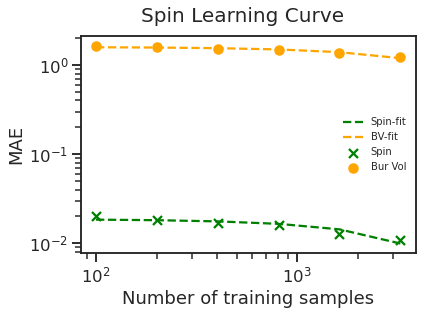

In [29]:
# now plot the learning curve of the MAE
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(num_train_list, spin_mae_list, c='green', marker="x", label='Spin')
ax1.scatter(num_train_list, bv_mae_list, c='orange', marker="o", label='Bur Vol')

z_spin = np.polyfit(num_train_log,spin_mae_log, 1)
z_bv = np.polyfit(num_train_log,bv_mae_log, 1)

p_spin = np.poly1d(z_spin)
p_bv = np.poly1d(z_bv)

x_spin, y_spin = [],[]
for i in range(len(spin_mae_log)):
    x_spin.append(num_train_log[i])
    y_spin.append(p_spin(num_train_log[i]))

x_bv, y_bv = [],[]
for i in range(len(bv_mae_log)):
    x_bv.append(num_train_log[i])
    y_bv.append(p_bv(num_train_log[i]))


ax1.plot(x_spin, y_spin, c='green', label='Spin-fit',linestyle='dashed')
ax1.plot(x_bv, y_bv, c='orange', label='BV-fit',linestyle='dashed')

fig.suptitle('Spin Learning Curve', fontsize=20)

ax1.set_xscale('log')
ax1.set_yscale('log')
# plt.xscale('log')
# plt.yscale('log')


# plt.axhline(y=0.025, color='k', linestyle='--')
# plt.axhline(y=0.043, color='k', linestyle='--',alpha=0.4)
# plt.text(100, 0.027, '25 mV')
# plt.text(100, 0.046, '1 kcal/mol')
plt.xlabel('Number of training samples')
plt.ylabel('MAE')
plt.legend(fontsize=10)
out_file = '2021-02-11-spin-bv-lc-MAE.jpg'
print(os.path.abspath(out_file))
fig.savefig(out_file, dpi=300, bbox_inches='tight')
plt.show()